In [19]:
import json
import pandas as pd
import seaborn as sns
import re
import pickle
# import mowl
# mowl.init_jvm("4g")
import networkx as nx
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt

## Load depth graph


In [20]:
big_G = {}

def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

big_G = read_json_file("../../Data/Output/8/MeSH_graph_with_depth.json")

print(big_G.nodes["D004628"]["Depth"])
print(big_G)

1
DiGraph with 30585 nodes and 41731 edges


## Frequency analysis of MeSH terms in RELISH abstracts

We will load a json file that contains all the MeSH terms that are mentioned in RELISH abstracts

In [21]:
MeSH_cnt = {}

'''
    Function to load a dataset containing the frequency of words and MeSH in RELISH abstracts.
    https://drive.google.com/file/d/1V2jviTCjTq2_qeh4z535P59wr0eCv5ZQ/view?usp=share_link

    Input:  path -> The path location of the json file.
    Output: A python dictionary {PMID : [[mesh_1,cnt_1], [mesh_2,cnt_2], ..., [mesh_n,cnt_n]] }
'''

def load_Dataset(path):
    global all_terms
    with open(path) as f:
        all_terms = json.load(f)

load_Dataset("../../Data/Output/3/Abstract2Graph_Cnt_Occurrence.json")

In [22]:
big_G_nodes = set([x[0] for x in list(big_G.nodes.items())])

for k in big_G_nodes:
    if(k not in MeSH_cnt):
        MeSH_cnt[k] = 0

'''
    Function to sum up the appearances of each individual MeSH term in the RESLISH abstracts.

    Input:  
    Output: A Dictionary with the  count of the appearances of a STY, when an STY appears its parents as well appear   
            {graph_id : CNT} the graph_id is the number representing a MeSH term in the graph representing the ontology.
'''
def count_MeSH_in_Dataset():
    for abstract_id in all_terms:
        MeSH_list = all_terms[abstract_id]
        for MeSH_raw,cnt in MeSH_list:
            #Remove the "MeSH" part of the abstract annotations 
            MeSH = MeSH_raw[4:len(str(MeSH_raw))]
            if MeSH in big_G_nodes:
                graph_id = MeSH
                if(graph_id in MeSH_cnt):
                    MeSH_cnt[graph_id] = MeSH_cnt[graph_id] + cnt
                else:
                    MeSH_cnt[graph_id] = cnt

count_MeSH_in_Dataset()

In [23]:
nx.set_node_attributes(big_G, MeSH_cnt, "Frequency")
print(big_G.nodes["D000067565"]["Frequency"])

1088


In [24]:
with open("../../Data/Output/8/RELISH_frequency_MeSH_graph_with_depth+freq.json", "w") as fp:
            json.dump(json_graph.node_link_data(big_G),fp,indent = 2) 

## Frequency visualization

    Depth in Mesh Tree  MeSH count
0                    1      297335
1                    2     1480080
2                    3     1508808
3                    4     1134249
4                    5      536608
5                    6      171902
6                    7       77592
7                    8       71579
8                    9       43060
9                   10       56942
10                  11       51595
11                  12        6659
12                  13        3054


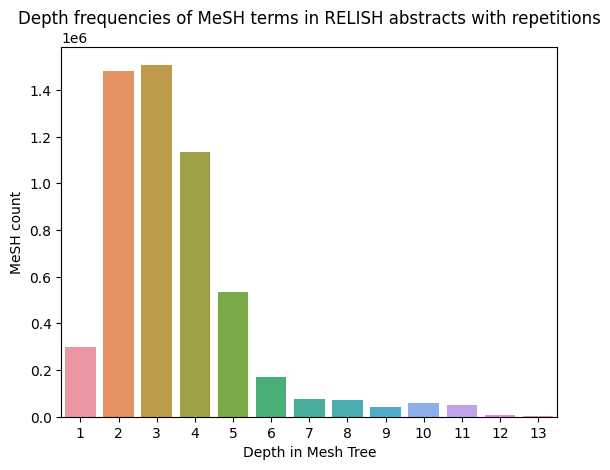

In [25]:
i = 0
Depth_vs_freq = {}
for node_id in big_G.nodes:
    if(node_id in big_G_nodes and MeSH_cnt[node_id] != 0):
        dpth = big_G.nodes[node_id]["Depth"]
        freq = big_G.nodes[node_id]["Frequency"]
        if(dpth in Depth_vs_freq): Depth_vs_freq[dpth] += freq
        else: Depth_vs_freq[dpth] = freq        
        i+=1
    # if(i == 20): break

sortedKeys = list(Depth_vs_freq.keys())
sortedKeys.sort()
Depth_vs_freq = {i: Depth_vs_freq[i] for i in sortedKeys}

df_Depth_vs_freq = pd.DataFrame()
df_Depth_vs_freq['Depth in Mesh Tree'] = list(Depth_vs_freq.keys())
df_Depth_vs_freq['MeSH count'] = list(Depth_vs_freq.values())

print(df_Depth_vs_freq)
sns.barplot(df_Depth_vs_freq, x="Depth in Mesh Tree", y="MeSH count").set(title='Depth frequencies of MeSH terms in RELISH abstracts with repetitions')
plt.savefig("../../Data/Images/Graphs/Depth_frequencies_MeSH_in_RELISH_abstracts_with_repetitions.png") 

## Addition of depth column to the hybridword2vec_all_idf dataset

The original hybridword2vec_all_idf dataset with a new column regarding 

In [28]:
path = "../../Data/Input/8/hybridword2vec_all_idf.tsv"
df_TP = pd.read_csv(path,sep='\t')
depths = []
for i in df_TP.index:
    node_id = str.upper(str(df_TP['word'][i])[4:len(str(df_TP['word'][i]))])
    if(node_id in big_G_nodes and MeSH_cnt[node_id] != 0):
        depths.append(big_G.nodes[node_id]["Depth"])
    else:
        depths.append(-1)

df_TP['Depth'] = depths

df_TP.to_csv("../../Data/Output/8/hybridword2vec_all_idf+depth.tsv",index=False,sep="\t")

print(df_TP.head(20))
print()  
print()  
print("Detph of node meshd012380: ",big_G.nodes["D012380"]["Depth"])       

    Unnamed: 0         word      df     idf  Depth
0            0          the  388889  0.1680     -1
1            1           of  370731  0.2158     -1
2            2          and  244784  0.6309     -1
3            3           in  377940  0.1965     -1
4            4           to  307461  0.4029     -1
5            5            a  445648  0.0317     -1
6            6           is  187264  0.8987     -1
7            7          for  174439  0.9697     -1
8            8           by  103204  1.4945     -1
9            9    catalyzes  131358  1.2533     -1
10          10         that  104053  1.4863     -1
11          11  meshd011506   86557  1.6704      2
12          12           as  177144  0.9543     -1
13          13         with   97517  1.5512     -1
14          14     involved   94278  1.5850     -1
15          15         from   84097  1.6993     -1
16          16  meshd012380   65290  1.9524      4
17          17           an  320220  0.3622     -1
18          18      complex   5